<a href="https://colab.research.google.com/github/eunhaday/AIFFEL_quest_cr/blob/master/MainQuest/QUEST03/0930_prj02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 : 폐렴 진단기 성능개선

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#X-RAY 사진 판독 폐렴 진단기
import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 실험환경 Set-up

In [ ]:
#------------------------
# 패키지(라이브러리)들을 import
#------------------------
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#------------------------
# 변수들을 생성
#------------------------

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#Batch size, Epoch 등을 변경
BATCH_SIZE = 20
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

 - 원본 데이터를 가져와서 전처리 및 배치 구성을 진행
 - augmentation 기법을 고려(데이터증강), 학습데이타의 정상건수가

 # 2-1. 데이터 가져오기

In [ ]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)  #학습데이타
test_filenames = tf.io.gfile.glob(TEST_PATH)  #test데이타
val_filenames = tf.io.gfile.glob(VAL_PATH)  #검증데이타

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [ ]:
#------------------------------------------------------------------------------------------------------
#train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할 (val 개수가 너무 없기 때문에)
#------------------------------------------------------------------------------------------------------

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [ ]:
#train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [ ]:
#파일경로 기준으로 train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인하기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [ ]:
#tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [ ]:
#Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [ ]:
#--------------------------------
#라벨 데이터 생성 함수작성
#--------------------------------

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
#--------------------------------
#이미지의 사이즈를 통일 (사이즈줄이기)
#--------------------------------

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
#train 데이터 셋과 validation 데이터 셋 생성

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
#수정된 이미지 사이즈 및 라벨 확인

for image, label in train_ds.take(1):  #하나의 데이터만 가져와서 확인
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [ ]:
#test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()  #test데이타셋 데이터 개수
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)  #16으로 설정

print(TEST_IMAGE_COUNT)

624


# 데이터 변환 (augmentation 기법)

In [ ]:
#데이터 변환 (augmentation 기법)
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label


def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

 - 학습용 데이터를 시각화해서 확인
 - augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인

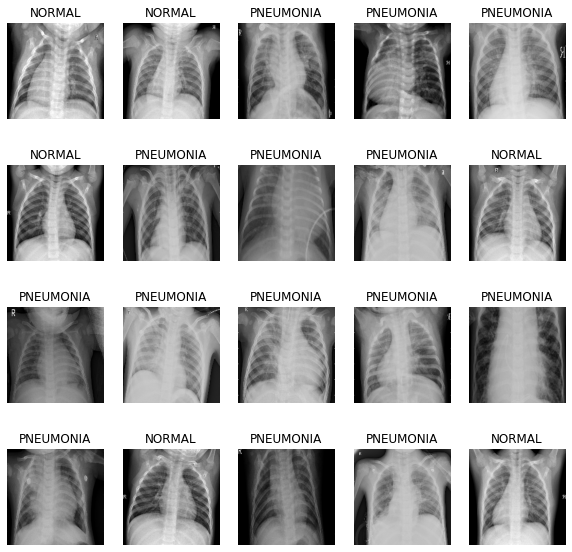

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):

        # 하위플롯의 그리드생성(행수:4, 서브플롯 그리드의 열수:16/4=4, 현재 서브플롯의 위치:n+1(1) )
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)   #20/4=5, 1
        plt.imshow(image_batch[n])

        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. ResNet-18 구현

 - Convolution filter, 채널 개수, activation, 모델 구조 변경
 - ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델
 - ResNet의 특징
   * Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지
   * 이후에 나오는 Transformer와 같은 모델에도 사용
 - ResNet의 가장 작은 버전인 ResNet-18로 구현
   * 3x3 CNN
   * BatchNormalization
   * 활성화 함수 ReLU로 구성

In [ ]:
# ResNet은 Residual block을 먼저 구성

# 모델을 만드는 데에 필요한 모듈 불러오기
import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.utils import plot_model # 모델 시각화

In [ ]:
#-----------------------------
#residual_module을 정의
#-----------------------------

def residual_module(input_layer, n_filters):
	merge_input = input_layer

# if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
	if input_layer.shape[-1] != n_filters:
		merge_input = keras.layers.Conv2D(n_filters, (1,1), padding='same', activation='relu')(input_layer) # n_filter로 채널 사이즈를 맞춰 준다.
	# Conv2D layer
	conv1 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(input_layer)
	# Conv2D layer
	conv2 = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='linear')(conv1)

  # Add를 통해서 skip connection을 구현하는 부분
	out_layer = keras.layers.Add()([conv2, merge_input])
	out_layer = keras.layers.Activation('relu')(out_layer)

	return out_layer

In [ ]:
def build_resnet(input_shape, num_classes):
    """Builds a simple ResNet model."""
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional layer
    x = layers.Conv2D(64, (7, 7), padding='same', strides=(2, 2))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add residual blocks
    for _ in range(2):
        x = residual_module(x, 64)

    for _ in range(2):
        x = residual_module(x, 128)

    for _ in range(2):
        x = residual_module(x, 256)

    for _ in range(2):
        x = residual_module(x, 512)

    # Global Average Pooling and Dense layer
    average_pool = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)
    return model

# Example usage
#input_shape = (256, 256, 3)  # Input image shape
#num_classes = 10  # Number of classes for classification
#model = build_resnet(input_shape, num_classes)
#model.summary()

# Step 5. 데이터 imbalance 처리

In [ ]:
#class_weight를 설정 생략

# Step 6. 모델 훈련

In [ ]:
with tf.device('/GPU:0'):

    input_shape = (180, 180, 3)  # Input image shape
    num_classes = 10  # Number of classes for classification
    model = build_resnet(input_shape, num_classes)


    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

NameError: name 'keras' is not defined

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,   #4185/16 = 261개
        epochs=EPOCHS,                                   #EPOCHS = 10
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE    #1047/16 = 65개
    )

NameError: name 'train_ds' is not defined

# 7. 결과 확인과 시각화

NameError: name 'history' is not defined

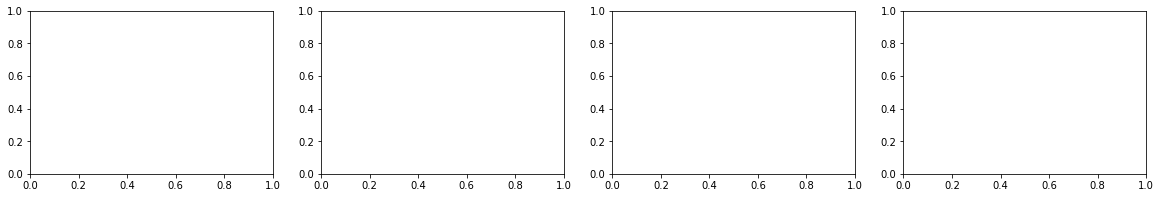

In [ ]:
#  Epochs 마다 모델의 precision, recall, accuracy, loss 변화 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
#테스트 데이터로 모델 평가 (loss, accuracy, precision, recall 값을 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)  #손실:loss, 정확도:accuracy, 정밀도:precision, 재현율:recall
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

NameError: name 'model' is not defined